In [25]:
#importing important libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Keras / TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

**Settings / Hyperparameters**

In [26]:

DATA_PATH = "engineered_scaled_fuel_access.csv"
LOOKBACK = 120       # number of past days used (timesteps)
HORIZON = 1          # days ahead to predict (1 => next day)
BATCH_SIZE = 16
EPOCHS = 100
VALIDATION_SPLIT = 0.1  # internal validation used during training
RANDOM_SEED = 42
TF_MODEL_PATH = "lstm_multioutput_model.h5"

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

**Load The Dataset**

In [27]:

df = pd.read_csv(DATA_PATH, parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

print("Loaded dataset rows:", len(df))
print("Columns:", df.columns.tolist())

Loaded dataset rows: 5024
Columns: ['date', 'year_x', 'month_x', 'day', 'firewood_demand_m3', 'unit', 'area', 'temperature_avg', 'temperature_min', 'temperature_max', 'rainfall_mm', 'humidity_avg', 'pressure_hpa', 'wind_speed_kmh', 'is_rainy_day', 'season', 'latitude', 'longitude', 'year_y', 'month_y', 'quarter', 'day_of_year', 'day_of_week', 'is_weekend', 'clean_fuel_access', 'country', 'country_code', 'series_name', 'series_code', 'firewood_demand_m3_lag_1', 'clean_fuel_access_lag_1', 'temperature_avg_lag_1', 'rainfall_mm_lag_1', 'firewood_demand_m3_lag_7', 'clean_fuel_access_lag_7', 'temperature_avg_lag_7', 'rainfall_mm_lag_7', 'firewood_demand_m3_lag_14', 'clean_fuel_access_lag_14', 'temperature_avg_lag_14', 'rainfall_mm_lag_14', 'firewood_demand_m3_lag_30', 'clean_fuel_access_lag_30', 'temperature_avg_lag_30', 'rainfall_mm_lag_30', 'fw_roll_mean_7', 'cf_roll_mean_7', 'fw_roll_std_7', 'cf_roll_std_7', 'fw_roll_mean_30', 'cf_roll_mean_30', 'fw_roll_std_30', 'cf_roll_std_30', 'fw_rol

**Selecting Feature and Target Columns**

In [28]:

# You should include only the columns produced by earlier FE that are useful.
# Keep this list manageable (too many features may lead to overfitting).
feature_cols = [
    # core weather + cyclical + lag/rolling features you engineered earlier.
    # adjust to what you have in engineered_scaled_fuel_access.csv
    'temperature_avg', 'rainfall_mm', 'humidity_avg',
    'sin_doy', 'cos_doy', 'is_weekend',
    'firewood_demand_m3_lag_1', 'firewood_demand_m3_lag_7', 'firewood_demand_m3_lag_30',
    'clean_fuel_access_lag_1', 'clean_fuel_access_lag_7', 'clean_fuel_access_lag_30',
    'fw_roll_mean_30', 'cf_roll_mean_30'
]

target_cols = ['firewood_demand_m3', 'clean_fuel_access']

# Ensure all columns exist
for c in feature_cols + target_cols:
    if c not in df.columns:
        raise ValueError(f"Required column '{c}' not found in dataframe. Adjust feature_cols list.")



**Chronological train/test split (avoiding data leakage)**

In [29]:
split_ratio = 0.8
split_idx = int(len(df) * split_ratio)

train_df = df.iloc[:split_idx].reset_index(drop=True).copy()
test_df  = df.iloc[split_idx:].reset_index(drop=True).copy()

print(f"Train rows: {len(train_df)} | Test rows: {len(test_df)}")
print("Train date range:", train_df['date'].min(), "→", train_df['date'].max())
print("Test date range:", test_df['date'].min(), "→", test_df['date'].max())

Train rows: 4019 | Test rows: 1005
Train date range: 2010-03-31 00:00:00 → 2021-03-31 00:00:00
Test date range: 2021-04-01 00:00:00 → 2023-12-31 00:00:00


**Sequence creation function**

In [30]:

def create_sequences(df_in, feature_columns, target_columns, lookback=120, horizon=1):
    """
    Create sliding-window sequences from df_in (chronological).
    Returns:
      X: np.array shape (n_samples, lookback, n_features)
      y: np.array shape (n_samples, n_targets)
    Notes:
      - df_in must be scaled already (no scaling here to avoid leakage).
      - This function creates samples only from the provided df slice (train/test separated).
    """
    data = df_in[feature_columns + target_columns].values
    n_obs = data.shape[0]
    n_features = len(feature_columns)
    n_targets = len(target_columns)

    Xs = []
    ys = []

    # sliding window: start from 0 to n_obs - lookback - horizon
    for start in range(0, n_obs - lookback - horizon + 1):
        end = start + lookback
        X = data[start:end, :n_features]                    # (lookback, n_features)
        y = data[end + horizon - 1, n_features:]             # targets at horizon point
        Xs.append(X)
        ys.append(y)

    Xs = np.array(Xs)
    ys = np.array(ys)
    return Xs, ys

# Create train sequences
X_train, y_train = create_sequences(train_df, feature_cols, target_cols, LOOKBACK, HORIZON)
X_test, y_test   = create_sequences(test_df, feature_cols, target_cols, LOOKBACK, HORIZON)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (3899, 120, 14)
y_train shape: (3899, 2)
X_test shape: (885, 120, 14)
y_test shape: (885, 2)


In [31]:
# ==============================================================
# (fixed output shape + joint weighted loss)
# ==============================================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# ✅ Define the model
model = Sequential([
    # First LSTM passes all timesteps forward
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    # Second LSTM outputs only the last timestep (to match y_train)
    LSTM(64, return_sequences=False),

    Dense(32, activation='relu'),

    # Two outputs — one for firewood, one for clean fuel
    Dense(2)
])

# ✅ Weighted loss: give more importance to one target if needed
def weighted_mse(y_true, y_pred, weights=[0.7, 0.3]):
    """
    Custom weighted MSE loss for multi-output regression.
    weights[0] -> firewood_demand_m3
    weights[1] -> clean_fuel_access
    """
    error = tf.square(y_true - y_pred)
    weighted_error = error * tf.constant(weights)
    return tf.reduce_mean(weighted_error)


firewood_std = np.std(y_train[:, 0])
fuel_std = np.std(y_train[:, 1])
weights = [1/firewood_std, 1/fuel_std]  # inversely proportional to variance

# Wrap it in a lambda for Keras
loss_fn = lambda y_true, y_pred: weighted_mse(y_true, y_pred, weights)


# ✅ Compile model
model.compile(optimizer='adam', loss=loss_fn, metrics=['mae'])

# ✅ Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# ✅ Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0952 - mae: 0.0906 - val_loss: 0.0624 - val_mae: 0.0895
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0481 - mae: 0.0600 - val_loss: 0.0637 - val_mae: 0.0809
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0476 - mae: 0.0593 - val_loss: 0.0627 - val_mae: 0.0782
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0460 - mae: 0.0586 - val_loss: 0.0605 - val_mae: 0.0812
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0449 - mae: 0.0575 - val_loss: 0.0503 - val_mae: 0.0739
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0440 - mae: 0.0566 - val_loss: 0.0490 - val_mae: 0.0705
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0436 - mae: 0.0565 - val_loss: 0.0486 - val_mae: 0.0630
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0433 - mae: 0.0564 - val_loss: 0.0465 - val_mae: 0.0593
Epoch 9/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/ste

**Building the multi output LSTM**

In [47]:
n_timesteps = X_train.shape[1]
n_features  = X_train.shape[2]
n_targets   = y_train.shape[1]

def build_lstm_model(timesteps, features, targets, units=128, dropout=0.1):
    model = Sequential()
    # You can try Bidirectional(LSTM) for more capacity if data allows
    model.add(LSTM(units, input_shape=(timesteps, features), return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(units//2, activation='relu'))
    model.add(Dense(targets))  # linear activation -> regression outputs
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_lstm_model(n_timesteps, n_features, n_targets, units=128, dropout=0.2)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 128)            │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,602 (318.76 KB)

 Trainable params: 81,602 (318.76 KB)

 Non-trainable params: 0 (0.00 B)

**Callbacks: early stopping + checkpoint**

In [44]:

es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint(TF_MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=1)

In [45]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Model output shape:", model.output_shape)


X_train shape: (3899, 120, 14)
y_train shape: (3899, 2)
Model output shape: (None, 120, 2)


**Train**

In [46]:
history = model.fit(
    X_train, y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, mc],
    shuffle=False  # IMPORTANT: do not shuffle time-series order
)


Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/mse/sub defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-1926686817.py", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 61, in train_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/compile_utils.py", line 690, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/compile_utils.py", line 699, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/losses/loss.py", line 67, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py", line 33, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py", line 1763, in mean_squared_error

required broadcastable shapes
	 [[{{node compile_loss/mse/sub}}]] [Op:__inference_multi_step_on_iterator_247597]

In [36]:
# Save history for analysis
history_df = pd.DataFrame(history.history)
history_df.to_csv("lstm_training_history.csv", index=False)


In [37]:
# 8) Evaluate on test set
# -----------------------------
eval_res = model.evaluate(X_test, y_test, verbose=1)
print("Test evaluation (loss, mae):", eval_res)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0155 - mae: 0.1077
Test evaluation (loss, mae): [0.022200003266334534, 0.12991271913051605]


**Predict and Plot Results**

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
y_true shape: (885, 2)
y_pred shape: (885, 2)
dates_test length: 200


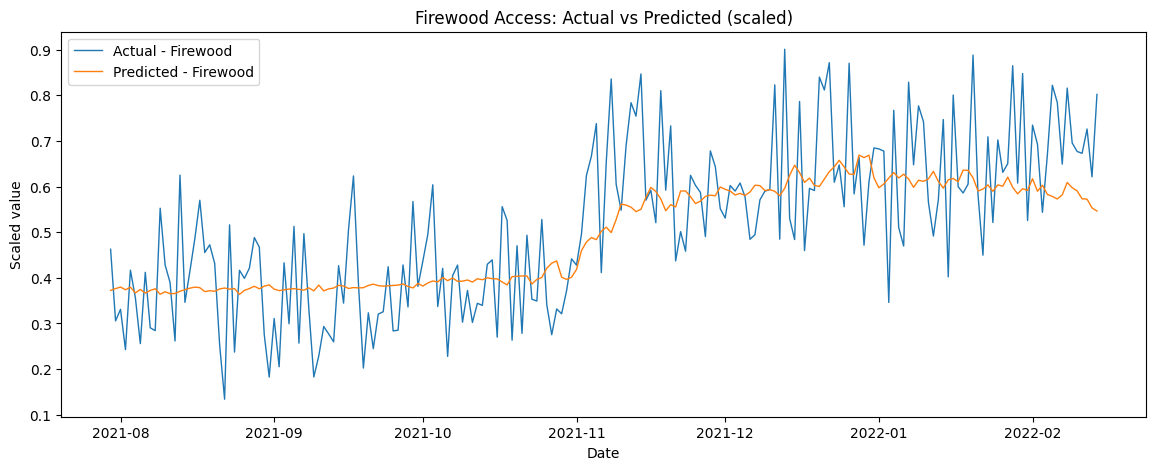

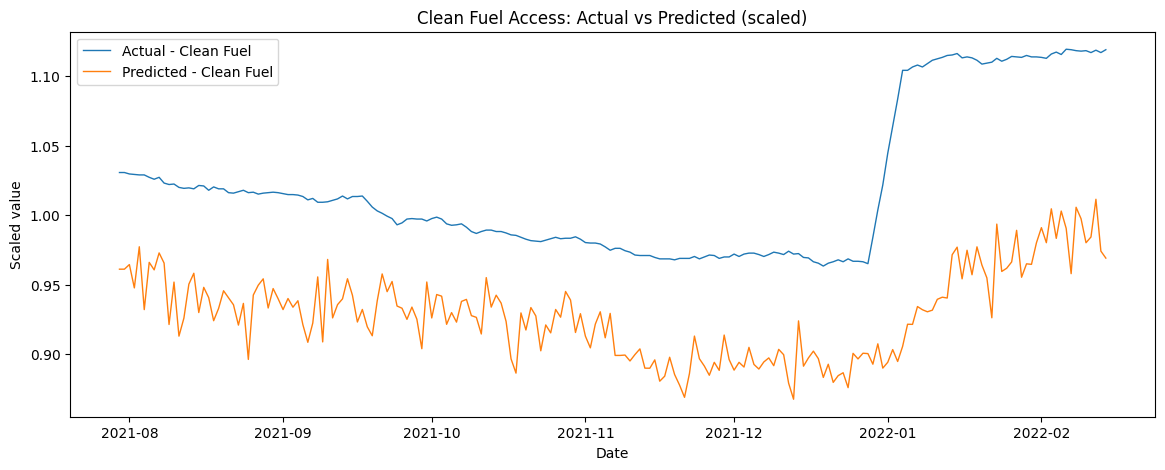

In [38]:
y_pred = model.predict(X_test)

# y_test and y_pred are in scaled units. To interpret them in original units,
# you'd inverse-transform using the scaler used earlier. Since the input file was scaled,
# we assume you still have that scaler object saved. If not, plots still show relative fit.

# Plot predictions vs actual for first 200 test samples
PLOT_N = min(200, len(y_test))
dates_test = test_df['date'].iloc[LOOKBACK + HORIZON - 1 : LOOKBACK + HORIZON - 1 + PLOT_N].reset_index(drop=True)
print("y_true shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)
print("dates_test length:", len(dates_test))

plt.figure(figsize=(14,5))
plt.plot(dates_test, y_test[:PLOT_N, 0], label='Actual - Firewood', linewidth=1)
plt.plot(dates_test, y_pred[:PLOT_N, 0], label='Predicted - Firewood', linewidth=1)
plt.title('Firewood Access: Actual vs Predicted (scaled)')
plt.xlabel('Date'); plt.ylabel('Scaled value')
plt.legend()
plt.show()

plt.figure(figsize=(14,5))
plt.plot(dates_test, y_test[:PLOT_N, 1], label='Actual - Clean Fuel', linewidth=1)
plt.plot(dates_test, y_pred[:PLOT_N, 1], label='Predicted - Clean Fuel', linewidth=1)
plt.title('Clean Fuel Access: Actual vs Predicted (scaled)')
plt.xlabel('Date'); plt.ylabel('Scaled value')
plt.legend()
plt.show()


**Save model and artifacts**

In [39]:
model.save("final_lstm_multioutput_model.h5")
print("Model saved to final_lstm_multioutput_model.h5")
print("Training history saved to lstm_training_history.csv")

Model saved to final_lstm_multioutput_model.h5
Training history saved to lstm_training_history.csv


In [40]:
# # Failsafe alignment
# min_len = min(len(y_true), len(aligned_dates))
# y_true = y_true[-min_len:]
# y_hat = y_hat[-min_len:]
# aligned_dates = aligned_dates[-min_len:]


**Diagnostics**

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Scaler loaded successfully from scaler.pkl

📊 Per-target evaluation metrics:
               target          MAE         RMSE     MAPE_%  Bias (pred-true)  \
0  firewood_demand_m3  3479.468969  4325.515397  12.319706       -531.496892   
1   clean_fuel_access     0.450342     0.480987   8.227505         -0.450342   

         R2  
0  0.413619  
1 -1.428463  

✅ Aligned 885 dates with 885 predictions.

Firewood Demand (m3) residual mean = 531.496892, std = 4292.737414


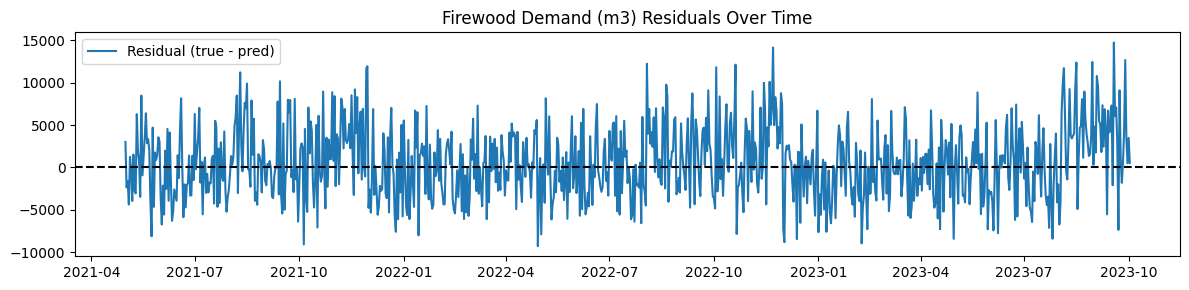

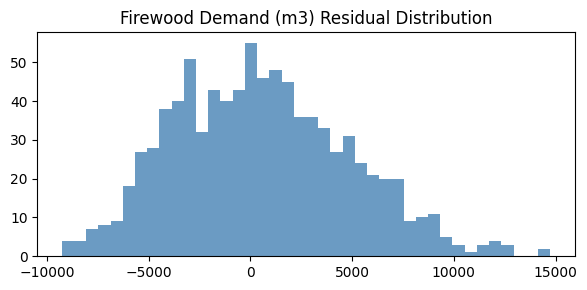


Clean Fuel Access residual mean = 0.450342, std = 0.168941


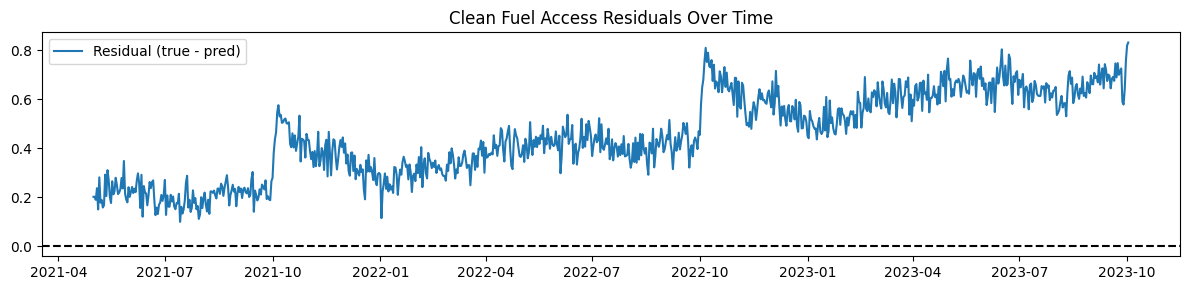

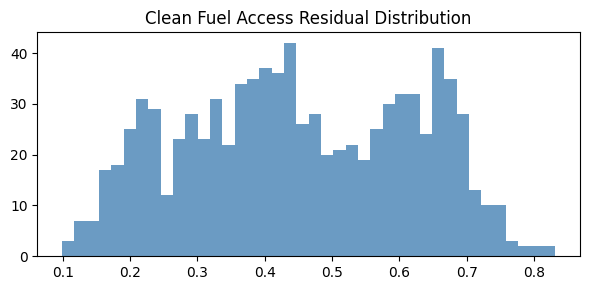

/tmp/ipython-input-2576425961.py:125: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_err.set_index('date').resample('M').agg({
/tmp/ipython-input-2576425961.py:139: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.title("🔥 Firewood Demand: Actual vs Predicted"); plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



📅 Monthly absolute error summary:
            abs_err_fw_mean  abs_err_fw_std  abs_err_cf_mean  abs_err_cf_std
date                                                                        
2021-05-31      3155.766781     2044.278145         0.225151        0.047331
2021-06-30      3359.247307     1902.456288         0.211925        0.047438
2021-07-31      2919.150059     1856.532294         0.176286        0.043734
2021-08-31      3702.351628     3013.405702         0.212380        0.036250
2021-09-30      3241.450366     3060.444824         0.222401        0.031897
2021-10-31      3680.927556     2605.697050         0.455798        0.066568
2021-11-30      4797.137007     3254.565047         0.381264        0.050735
2021-12-31      3680.198349     2020.966053         0.315630        0.049792
2022-01-31      3491.134972     2100.644878         0.276584        0.052463
2022-02-28      3043.832347     1788.187596         0.319563        0.036043
2022-03-31      2544.127959     1834.9122

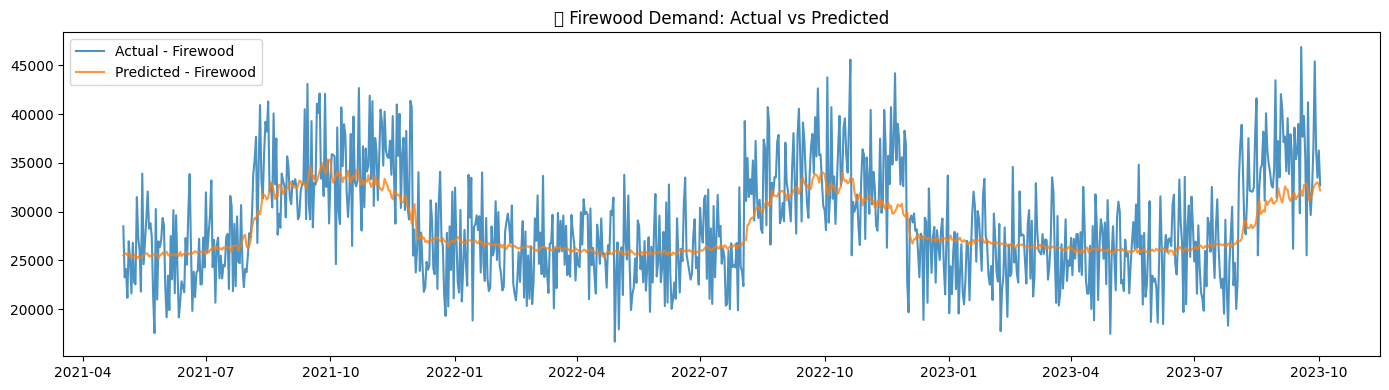

/tmp/ipython-input-2576425961.py:145: UserWarning: Glyph 9981 (\N{FUEL PUMP}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.title("⛽ Clean Fuel Access: Actual vs Predicted"); plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9981 (\N{FUEL PUMP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


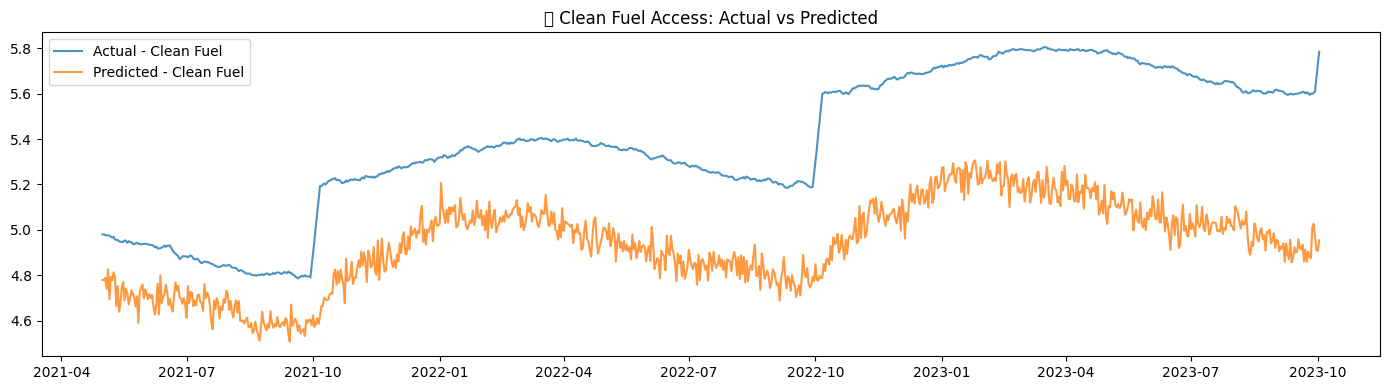

In [41]:
# ==============================================================
# ✅ CLEANCOOK MODEL DIAGNOSTICS — SAFE, AUTO-ALIGNING VERSION
# ==============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --------------------------------------------------------------
# 1️⃣ Load scaler and inverse-transform if available
# --------------------------------------------------------------
try:
    scaler = joblib.load("scaler.pkl")  # your fitted scaler
    print("Scaler loaded successfully from scaler.pkl")
except FileNotFoundError:
    scaler = None
    print("⚠️ Warning: scaler.pkl not found — metrics will be in scaled units")

def inv_targets(y_scaled, scaler_obj, target_count=2):
    """Inverse-transform scaled target values using previously fitted scaler."""
    n = y_scaled.shape[0]
    n_total_cols = scaler_obj.n_features_in_
    tmp = np.zeros((n, n_total_cols))
    tmp[:, -target_count:] = y_scaled
    inv_all = scaler_obj.inverse_transform(tmp)
    return inv_all[:, -target_count:]

if scaler is not None:
    y_test_inv = inv_targets(y_test, scaler)
    y_pred_inv = inv_targets(y_pred, scaler)
else:
    y_test_inv, y_pred_inv = y_test, y_pred  # stay scaled if scaler missing

# --------------------------------------------------------------
# 2️⃣ Metrics (per target)
# --------------------------------------------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def bias(y_true, y_pred):
    return np.mean(y_pred - y_true)

targets = ["firewood_demand_m3", "clean_fuel_access"]
rows = []
for i, name in enumerate(targets):
    true, pred = y_test_inv[:, i], y_pred_inv[:, i]
    rows.append({
        "target": name,
        "MAE": mean_absolute_error(true, pred),
        "RMSE": rmse(true, pred),
        "MAPE_%": mape(true, pred),
        "Bias (pred-true)": bias(true, pred),
        "R2": r2_score(true, pred)
    })
metrics_df = pd.DataFrame(rows)
print("\n📊 Per-target evaluation metrics:")
print(metrics_df)

# --------------------------------------------------------------
# 3️⃣ AUTO-ALIGN DATES SAFELY
# --------------------------------------------------------------
# Detect lookback (most users set it manually in sequence creation)
# If you know it, override below
LOOKBACK = 30  # change if you trained with 60 or 90

# Extract the full test dates directly from your test_df (must have 'date' column)
dates_full = pd.to_datetime(test_df['date']).values

# Drop first LOOKBACK rows to align with LSTM sequences
if len(dates_full) > len(y_test):
    aligned_dates = dates_full[LOOKBACK:LOOKBACK+len(y_test)]
else:
    aligned_dates = dates_full[-len(y_test):]

# Failsafe: ensure equal lengths even if slightly off
min_len = min(len(y_test), len(aligned_dates))
y_true = y_test_inv[-min_len:]
y_hat  = y_pred_inv[-min_len:]
aligned_dates = aligned_dates[-min_len:]
print(f"\n✅ Aligned {len(aligned_dates)} dates with {len(y_true)} predictions.")

# --------------------------------------------------------------
# 4️⃣ Residual plots
# --------------------------------------------------------------
def plot_residuals(true, pred, dates, target_name):
    resid = true - pred
    print(f"\n{target_name} residual mean = {resid.mean():.6f}, std = {resid.std():.6f}")
    plt.figure(figsize=(12,3))
    plt.plot(dates, resid, label='Residual (true - pred)')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f"{target_name} Residuals Over Time")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,3))
    plt.hist(resid, bins=40, color='steelblue', alpha=0.8)
    plt.title(f"{target_name} Residual Distribution")
    plt.tight_layout()
    plt.show()

plot_residuals(y_true[:,0], y_hat[:,0], aligned_dates, "Firewood Demand (m3)")
plot_residuals(y_true[:,1], y_hat[:,1], aligned_dates, "Clean Fuel Access")

# --------------------------------------------------------------
# 5️⃣ Monthly error breakdown
# --------------------------------------------------------------
df_err = pd.DataFrame({
    "date": pd.to_datetime(aligned_dates),
    "true_fw": y_true[:,0],
    "pred_fw": y_hat[:,0],
    "true_cf": y_true[:,1],
    "pred_cf": y_hat[:,1]
})
df_err['abs_err_fw'] = np.abs(df_err['true_fw'] - df_err['pred_fw'])
df_err['abs_err_cf'] = np.abs(df_err['true_cf'] - df_err['pred_cf'])
monthly = df_err.set_index('date').resample('M').agg({
    'abs_err_fw': ['mean','std'],
    'abs_err_cf': ['mean','std']
})
monthly.columns = ['_'.join(c) for c in monthly.columns]
print("\n📅 Monthly absolute error summary:")
print(monthly)

# --------------------------------------------------------------
# 6️⃣ Plot actual vs predicted
# --------------------------------------------------------------
plt.figure(figsize=(14,4))
plt.plot(aligned_dates, y_true[:,0], label='Actual - Firewood', alpha=0.8)
plt.plot(aligned_dates, y_hat[:,0], label='Predicted - Firewood', alpha=0.8)
plt.legend(); plt.title("🔥 Firewood Demand: Actual vs Predicted"); plt.tight_layout()
plt.show()

plt.figure(figsize=(14,4))
plt.plot(aligned_dates, y_true[:,1], label='Actual - Clean Fuel', alpha=0.8)
plt.plot(aligned_dates, y_hat[:,1], label='Predicted - Clean Fuel', alpha=0.8)
plt.legend(); plt.title("⛽ Clean Fuel Access: Actual vs Predicted"); plt.tight_layout()
plt.show()


In [42]:
from sklearn.linear_model import LinearRegression

def bias_correct(y_true, y_pred):
    """Fits linear regression y_true ~ y_pred for bias correction."""
    model = LinearRegression()
    model.fit(y_pred.reshape(-1,1), y_true)
    y_calibrated = model.predict(y_pred.reshape(-1,1))
    slope, intercept = model.coef_[0], model.intercept_
    print(f"Calibration: slope={slope:.3f}, intercept={intercept:.3f}")
    return y_calibrated

# Apply calibration per target
for i, name in enumerate(["Firewood Demand", "Clean Fuel Access"]):
    y_true_t = y_test_inv[:, i]
    y_pred_t = y_pred_inv[:, i]
    y_calibrated = bias_correct(y_true_t, y_pred_t)

    print(f"\n{name} — Post-Calibration Metrics:")
    print(" MAE:", mean_absolute_error(y_true_t, y_calibrated))
    print(" RMSE:", np.sqrt(mean_squared_error(y_true_t, y_calibrated)))
    print(" R²:", r2_score(y_true_t, y_calibrated))


Calibration: slope=1.362, intercept=-9672.070

Firewood Demand — Post-Calibration Metrics:
 MAE: 3401.6876128099807
 RMSE: 4171.624221380061
 R²: 0.4546004924221059
Calibration: slope=1.464, intercept=-1.840

Clean Fuel Access — Post-Calibration Metrics:
 MAE: 0.11882883191755943
 RMSE: 0.1452418017810064
 R²: 0.7785644375823574


Epoch 1/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0139 - mae: 0.1142 - val_loss: 0.0068 - val_mae: 0.0799
Epoch 2/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0056 - mae: 0.0613 - val_loss: 0.0070 - val_mae: 0.0674
Epoch 3/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0055 - mae: 0.0617 - val_loss: 0.0061 - val_mae: 0.0651
Epoch 4/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0053 - mae: 0.0604 - val_loss: 0.0054 - val_mae: 0.0604
Epoch 5/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0052 - mae: 0.0599 - val_loss: 0.0055 - val_mae: 0.0571
Epoch 6/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0052 - mae: 0.0591 - val_loss: 0.0053 - val_mae: 0.0575
Epoch 7/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0051 - mae: 0.0591 - val_loss: 0.0052 - val_mae: 0.0561
Epoch 8/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0051 - mae: 0.0586 - val_loss: 0.0052 - val_mae: 0.0570
Epoch 9/100
244/244 ━━━━━━━━━━━━━━━━━━━━

,epoch,val_loss,val_mae,mse_firewood,mse_cleanfuel
95,96,0.004136,0.052042,0.011614,0.000474
96,97,0.004042,0.050725,0.011358,0.000441
97,98,0.004101,0.050869,0.011508,0.000489
98,99,0.004115,0.051263,0.011558,0.000465
99,100,0.004289,0.051389,0.012087,0.000393


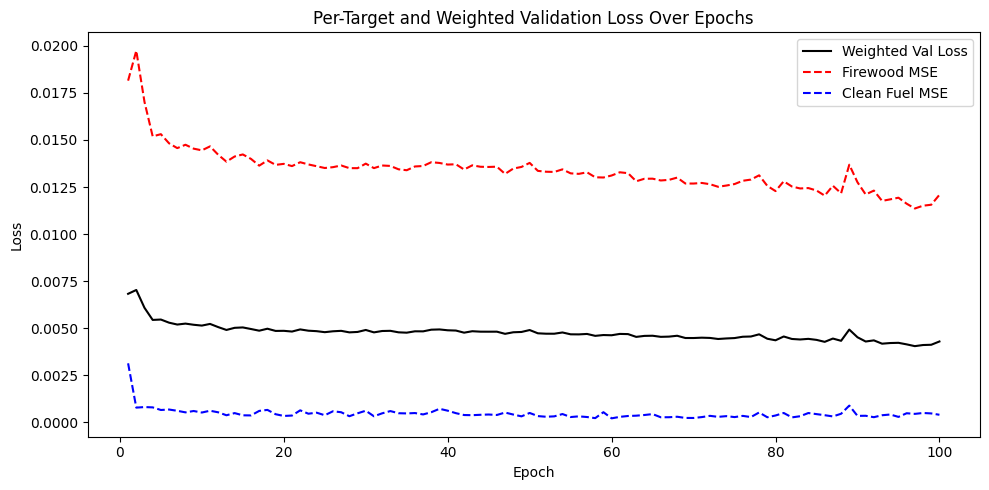

In [48]:
# ==============================================================
# 🎯 Weighted-Loss Tracking & Visualization for Multi-Output LSTM
# ==============================================================

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- keep your weighted_mse as before
def weighted_mse(y_true, y_pred, weights=[0.7, 0.3]):
    error = tf.square(y_true - y_pred)
    weighted_error = error * tf.constant(weights)
    return tf.reduce_mean(weighted_error)

# --- helper functions to compute per-target losses (unweighted)
def mse_per_target(y_true, y_pred):
    """Returns a tuple (mse_firewood, mse_cleanfuel)"""
    mse_fw  = tf.reduce_mean(tf.square(y_true[:, 0] - y_pred[:, 0]))
    mse_fuel = tf.reduce_mean(tf.square(y_true[:, 1] - y_pred[:, 1]))
    return mse_fw, mse_fuel


# --- Custom Callback to log per-target MSE each epoch
class PerTargetLossLogger(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        mse_fw, mse_fuel = mse_per_target(
            tf.constant(self.y_val, dtype=tf.float32),
            tf.constant(y_pred, dtype=tf.float32)
        )
        self.history.append({
            'epoch': epoch + 1,
            'val_loss': logs.get('val_loss'),
            'val_mae': logs.get('val_mae'),
            'mse_firewood': float(mse_fw.numpy()),
            'mse_cleanfuel': float(mse_fuel.numpy())
        })

# ==============================================================
# 🧠 Rebuild and Train Model with Callback
# ==============================================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(2)
])

loss_fn = lambda y_true, y_pred: weighted_mse(y_true, y_pred, [0.7, 0.3])
model.compile(optimizer='adam', loss=loss_fn, metrics=['mae'])

# Create validation split manually (e.g., 10%)
split_idx = int(len(X_train) * 0.9)
X_val, y_val = X_train[split_idx:], y_train[split_idx:]

logger = PerTargetLossLogger(X_val, y_val)
early_stop = EarlyStopping(patience=15, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, logger],
    verbose=1
)

# ==============================================================
# 📈 Visualize Weighted vs. Per-Target Loss
# ==============================================================

df_hist = pd.DataFrame(logger.history)
print("\nLogged per-target validation MSE over epochs:")
display(df_hist.tail())

plt.figure(figsize=(10,5))
plt.plot(df_hist['epoch'], df_hist['val_loss'], label='Weighted Val Loss', color='black')
plt.plot(df_hist['epoch'], df_hist['mse_firewood'], label='Firewood MSE', color='red', linestyle='--')
plt.plot(df_hist['epoch'], df_hist['mse_cleanfuel'], label='Clean Fuel MSE', color='blue', linestyle='--')
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Per-Target and Weighted Validation Loss Over Epochs")
plt.legend(); plt.tight_layout(); plt.show()
